In [11]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import inflect
import re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from nltk.corpus import stopwords
import numpy as np


nltk.download('stopwords')
nltk.download('gutenberg', quiet=True)
nltk.download('punkt', quiet=True)

imdb_data = pd.read_csv(r'https://raw.githubusercontent.com/BubbleNeumann/University-tasks/master/sem8_nlp_lab2/dataset.csv')
print(imdb_data.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(50000, 2)


#### Шаг №1 Подготовка данных

Обязательно предобработайте данные!



In [12]:
def prep(x):
    x = re.sub(r'<br />', '', x.lower())
    x = re.sub(r'[^\w\s]', '', x)
    tokens = word_tokenize(x)

    # replace digits with their text representation
    infl = inflect.engine()
    sentence = re.sub(r'\d+', lambda match: infl.number_to_words(match.group()), x)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # join the filtered tokens back into a sentence
    return ' '.join(filtered_tokens)

In [13]:
x_data, y_data = imdb_data['review'], imdb_data['sentiment']

y_train = y_data.apply(lambda x: int(x.startswith('p')))
x_train, x_test, y_train, y_test = train_test_split(x_data, y_train, test_size=0.9)

x_train = list(map(prep, x_train))

В качестве исследуемых способов представления текстов необходимо рассмотреть:

#### 1.Компоненты вектора: частоты ([CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).

In [14]:
%%time
# cv = CountVectorizer()
x_cv = CountVectorizer().fit_transform(x_train)

CPU times: user 240 ms, sys: 1 ms, total: 241 ms
Wall time: 243 ms


#### 2. Компоненты вектора: оценки tf-idf для слова ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).

In [15]:
%%time
x_tfidf = TfidfVectorizer().fit_transform(x_train)

CPU times: user 272 ms, sys: 1.01 ms, total: 273 ms
Wall time: 276 ms


#### 3. Компоненты вектора: частоты N-грам.

In [16]:
%%time
x_ngram = CountVectorizer(ngram_range=(3, 3)).fit_transform(x_train)

CPU times: user 792 ms, sys: 44.9 ms, total: 837 ms
Wall time: 838 ms


### Шаг 2. Исследование моделей

<table>
		<tr>
			<td></td>
			<td>$y = 1$</td>
			<td>$y = 0$</td>
		</tr>
		<tr>
			<td>$a(x) = 1$</td>
			<td>True Positive (TP)</td>
			<td>False Positive (FP)</td>
		</tr>
    	<tr>
			<td>$a(x) = 0$</td>
			<td>False Negative (FN)</td>
			<td>True Negative (TN)</td>
		</tr>
</table>

В зависимости от способа представления оценить качество классификации как долю правильных ответов на выборке ($\operatorname{accuracy} = \frac{\operatorname{TP} + \operatorname{TN}}{\operatorname{TP} + \operatorname{TN} + \operatorname{FP} + \operatorname{FN}}$). Используйте перекрестную проверку ([cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)).

Для каждого из нижеперечисленных моделей необходимо определить оптимальные гиперпараметры ([GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html))

Качество классификации оцениваем для следующих моделей:

#### 1. Машина опорных векторов ([SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)).

In [17]:
%%time

stats_svc = []

for X in [x_cv, x_tfidf, x_ngram]:
    clf = GridSearchCV(
        SVC(),
        {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'gamma': [0.1, 0.01, 0.001], 'C': [0.1, 1, 10, 25], }
    )
    clf.fit(X, y_train) # fit on the transformed data
    cl = SVC(kernel=clf.best_params_['kernel'], C=clf.best_params_['C'], gamma=clf.best_params_['gamma'])
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)  # define 5-fold cross-validation
    acc = cross_val_score(cl, X, y_train, cv=k_fold, scoring='accuracy') # evaluate accuracy
    stats_svc.append((clf.best_params_, acc))

CPU times: user 23min 38s, sys: 1.54 s, total: 23min 39s
Wall time: 23min 40s


#### 2. Случайный лес ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).

In [18]:
%%time

stats_rfc = []

for X in [x_cv, x_tfidf, x_ngram]:
    clf = GridSearchCV(
        RandomForestClassifier(random_state=1234),
        {'n_estimators': [10, 200, 1000], 'criterion': ('gini', 'entropy', 'log_loss')}
    )
    clf.fit(X, y_train)
    cl = RandomForestClassifier(criterion=clf.best_params_['criterion'], random_state=1234, n_estimators=clf.best_params_['n_estimators'])
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)  # define 5-fold cross-validation
    acc = cross_val_score(cl, X, y_train, cv=k_fold, scoring='accuracy')
    stats_rfc.append((clf.best_params_, acc))

CPU times: user 1h 23min 1s, sys: 5.72 s, total: 1h 23min 7s
Wall time: 1h 23min 8s


### Шаг 3. Сравнение результатов

Сравнить точность обученных моделей. Найти наиболее точную.

In [19]:
for e in zip(['CountVectorizer', 'TfidfVectorizer', 'Ngrams' ], stats_svc):
    print(e)

for e in zip(['CountVectorizer', 'TfidfVectorizer', 'Ngrams' ], stats_rfc):
    print(e)

('CountVectorizer', ({'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}, array([0.79      , 0.81      , 0.8       , 0.81333333, 0.81666667])))
('TfidfVectorizer', ({'C': 25, 'gamma': 0.01, 'kernel': 'rbf'}, array([0.82333333, 0.84      , 0.8       , 0.85333333, 0.81333333])))
('Ngrams', ({'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid'}, array([0.59      , 0.64666667, 0.61      , 0.65333333, 0.60333333])))
('CountVectorizer', ({'criterion': 'gini', 'n_estimators': 1000}, array([0.86      , 0.84333333, 0.80666667, 0.80666667, 0.77      ])))
('TfidfVectorizer', ({'criterion': 'entropy', 'n_estimators': 1000}, array([0.82333333, 0.80333333, 0.80333333, 0.82666667, 0.76      ])))
('Ngrams', ({'criterion': 'entropy', 'n_estimators': 10}, array([0.53      , 0.53666667, 0.49      , 0.54      , 0.48333333])))


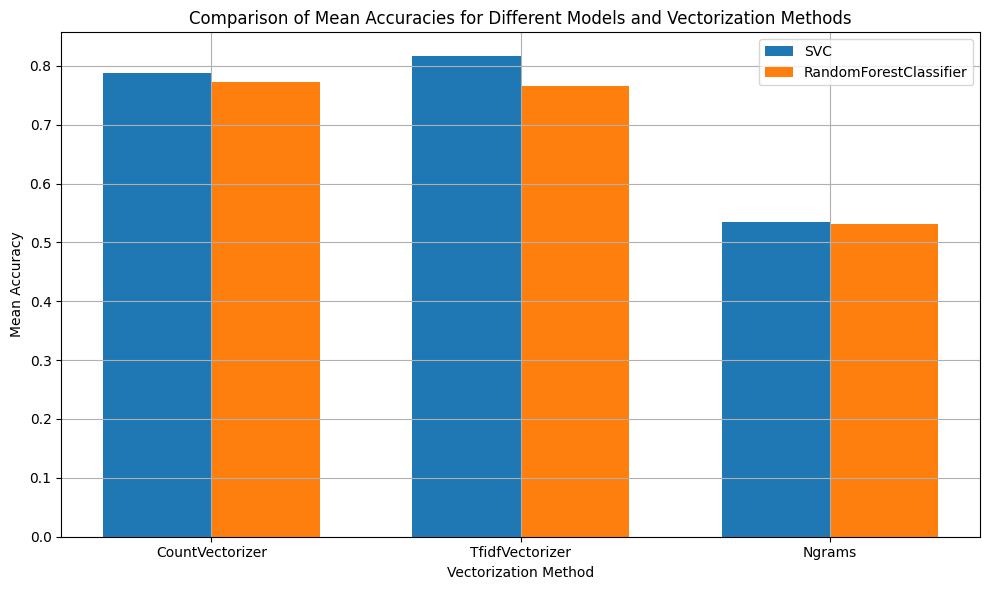

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data
accuracy_data = [
    ('SVC', 'CountVectorizer', [0.79, 0.81, 0.72, 0.8 , 0.82]),
    ('SVC', 'TfidfVectorizer', [0.78, 0.85, 0.79, 0.78, 0.88]),
    ('SVC', 'Ngrams', [0.54, 0.53, 0.54, 0.56, 0.5]),
    ('RandomForestClassifier', 'CountVectorizer', [0.72, 0.82, 0.78, 0.73, 0.81]),
    ('RandomForestClassifier', 'TfidfVectorizer', [0.76, 0.82, 0.74, 0.73, 0.78]),
    ('RandomForestClassifier', 'Ngrams', [0.52, 0.53, 0.53, 0.52, 0.56])
]

# Organizing data
models = ['SVC', 'RandomForestClassifier']
methods = ['CountVectorizer', 'TfidfVectorizer', 'Ngrams']
mean_accuracies = {model: {method: np.mean([scores for m, n, scores in accuracy_data if m == model and n == method]) for method in methods} for model in models}

# Plotting
plt.figure(figsize=(10, 6))

x = np.arange(len(methods))
width = 0.35

for i, model in enumerate(models):
    plt.bar(x + i * width, mean_accuracies[model].values(), width=width, label=model)

plt.xlabel('Vectorization Method')
plt.ylabel('Mean Accuracy')
plt.title('Comparison of Mean Accuracies for Different Models and Vectorization Methods')
plt.xticks(x + width / 2, methods)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
